<a href="https://colab.research.google.com/github/alibekk93/soccer_fun_stuff/blob/main/FBRef_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FBRef data getter
https://fbref.com/en/

## Setup

In [1]:
!pip install requests_html

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.2 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=8712e3e0ce928e13526b9ba3a482d9572eea653c24ac25f284ec3a4cfc6c9e74
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.6
    Uninstalling urllib3-2.0.6:
      Successfully uninstalled urllib3-2.0.6


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import requests
from requests_html import HTMLSession
from bs4 import BeautifulSoup

In [30]:
ELP_summary_2022 = pd.read_csv('/content/EPL_2022_player_summary.csv')

## Summary Tables

In [5]:
def get_team_summary_table(tables:list, table_index:int=0) -> pd.DataFrame():
  """Parses team summary table given a list of all tables from URL
  """
  table = tables[table_index]

  all_headers = [th.text for th in table.find_all('th')]
  data_headers_s = all_headers.index('Nation')
  data_headers_e = all_headers.index('Matches')
  table_headers = all_headers[data_headers_s:data_headers_e]
  table_headers[-10:] = ['p90_' + th for th in table_headers[-10:]]
  player_names = all_headers[data_headers_e+1:-2]
  table_data = [th.text for th in table.find_all('td')]
  table_data_cleaned = [r.tolist()[:-1] for r in np.array(table_data).reshape(-1, 33)][:-2]

  summary_df = pd.DataFrame(table_data_cleaned, columns=table_headers)
  summary_df['Player'] = player_names

  summary_df = summary_df[summary_df['Min']!='']

  return summary_df

In [12]:
def convert_numeric_columns(df):
    for col in df.columns:
      try:
        df.loc[:, col] = df.loc[:, col].str.replace(',', '').astype(float)
      except:
        pass
    return df

## Within-team normalization

In [46]:
ELP_summary_2022['p90_CrdY'] = ELP_summary_2022['CrdY'] / ELP_summary_2022['Min']
ELP_summary_2022['p90_CrdR'] = ELP_summary_2022['CrdR'] / ELP_summary_2022['Min']

In [47]:
ELP_summary_2022.columns

Index(['Nation', 'Pos', 'Age', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast',
       'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG',
       'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'p90_Gls', 'p90_Ast', 'p90_G+A',
       'p90_G-PK', 'p90_G+A-PK', 'p90_xG', 'p90_xAG', 'p90_xG+xAG', 'p90_npxG',
       'p90_npxG+xAG', 'Player', 'Team', 'p90_CrdY', 'p90_CrdR'],
      dtype='object')

In [48]:
feature_colums = ['p90_npxG', 'p90_xAG', 'p90_CrdY', 'p90_CrdR']

In [50]:
ELP_summary_2022[feature_colums]

,p90_npxG,p90_xAG,p90_CrdY,p90_CrdR
0,0.00,0.01,0.000952,0.0
1,0.14,0.13,0.001718,0.0
2,0.75,0.17,0.001806,0.0
3,0.21,0.51,0.000414,0.0
4,0.26,0.13,0.000000,0.0
...,...,...,...,...
564,0.00,0.00,0.000000,0.0
565,0.00,0.00,0.000000,0.0
566,0.00,0.00,0.000000,0.0
567,0.00,0.86,0.000000,0.0


## Getting data

In [ ]:
team_urls =   ['https://fbref.com/en/squads/b8fd03ef/2022-2023/Manchester-City-Stats',
               'https://fbref.com/en/squads/18bb7c10/2022-2023/Arsenal-Stats',
               'https://fbref.com/en/squads/19538871/2022-2023/Manchester-United-Stats',
               'https://fbref.com/en/squads/b2b47a98/2022-2023/Newcastle-United-Stats',
               'https://fbref.com/en/squads/822bd0ba/2022-2023/Liverpool-Stats',
               'https://fbref.com/en/squads/d07537b9/2022-2023/Brighton-and-Hove-Albion-Stats',
               'https://fbref.com/en/squads/8602292d/2022-2023/Aston-Villa-Stats',
               'https://fbref.com/en/squads/361ca564/2022-2023/Tottenham-Hotspur-Stats',
               'https://fbref.com/en/squads/cd051869/2022-2023/Brentford-Stats',
               'https://fbref.com/en/squads/fd962109/2022-2023/Fulham-Stats',
               'https://fbref.com/en/squads/47c64c55/2022-2023/Crystal-Palace-Stats',
               'https://fbref.com/en/squads/cff3d9bb/2022-2023/Chelsea-Stats',
               'https://fbref.com/en/squads/8cec06e1/2022-2023/Wolverhampton-Wanderers-Stats',
               'https://fbref.com/en/squads/7c21e445/2022-2023/West-Ham-United-Stats',
               'https://fbref.com/en/squads/4ba7cbea/2022-2023/Bournemouth-Stats',
               'https://fbref.com/en/squads/e4a775cb/2022-2023/Nottingham-Forest-Stats',
               'https://fbref.com/en/squads/d3fd31cc/2022-2023/Everton-Stats',
               'https://fbref.com/en/squads/a2d435b3/2022-2023/Leicester-City-Stats',
               'https://fbref.com/en/squads/5bfb9659/2022-2023/Leeds-United-Stats',
               'https://fbref.com/en/squads/33c895d4/2022-2023/Southampton-Stats',]

In [ ]:
# getting data loop

session = HTMLSession()
dfs = []

for url in tqdm(team_urls):
  r = session.get(url)
  team = url.split('/')[-1][:-6]
  soup = BeautifulSoup(r.html.raw_html)
  tables = soup.find_all('table')
  team_summary = get_team_summary_table(tables)
  team_summary['Team'] = team
  dfs.append(team_summary)

summary_data = pd.concat(dfs)
summary_data = convert_numeric_columns(summary_data)

summary_data.to_csv('EPL_2022_player_summary.csv', index=False)

<Axes: xlabel='Team', ylabel='Min'>

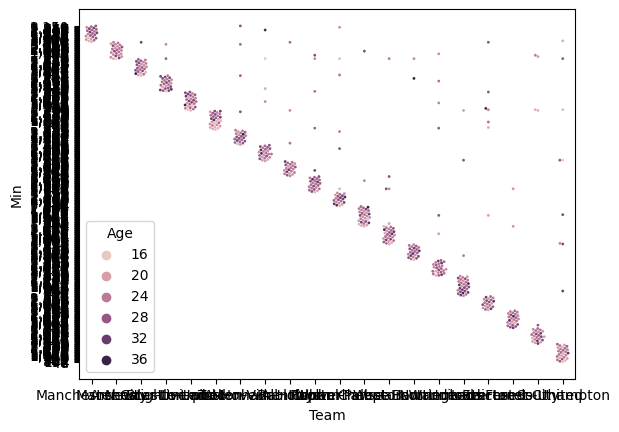

In [135]:
sns.swarmplot(data=summary_data.iloc[:50, :], x='Team', y='Min', hue='Age', size=2)